In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# CASE a>0

In [2]:
a = 1

In [3]:
def nonlin_center(x, y):
    """ODE system.
    dx/dt = -y + a*x(x^2+y^2)
    dy/dt = x + a*y(x^2+y^2)
    """
    x1 = y[:, 0:1]
    y1 = y[:, 1:]
    dx = dde.grad.jacobian(y, x, i=0)
    dy = dde.grad.jacobian(y, x, i=1)
    return [dx + y1 - a*x1*(x1**2+y1**2), dy- x1 - a*y1*(x1**2+y1**2)]


def boundary(_, on_initial):
    return on_initial

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )


In [4]:
geom = dde.geometry.TimeDomain(0, 15)
ic1 = dde.IC(geom, lambda X: 0.1, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 0.1, boundary, component=1)
data = dde.data.PDE(geom, nonlin_center, [ic1, ic2], 100, 2, num_test=100)

C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "


In [5]:
layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
# net.apply_feature_transform(input_transform)

Compiling model...
Building feed-forward neural network...
'build' took 0.075077 s



C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:107: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.415575 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.64e-01, 1.29e+00, 1.00e-02, 1.00e-02]    [6.74e-01, 1.29e+00, 1.00e-02, 1.00e-02]    []  
1000      [1.70e-04, 2.54e-04, 6.85e-06, 5.86e-06]    [1.76e-04, 1.97e-04, 6.85e-06, 5.86e-06]    []  
2000      [1.49e-04, 1.81e-04, 3.87e-06, 3.81e-06]    [1.51e-04, 1.56e-04, 3.87e-06, 3.81e-06]    []  
3000      [1.25e-04, 1.46e-04, 2.53e-06, 2.61e-06]    [1.27e-04, 1.38e-04, 2.53e-06, 2.61e-06]    []  
4000      [1.13e-04, 1.36e-04, 1.99e-06, 2.14e-06]    [1.17e-04, 1.33e-04, 1.99e-06, 2.14e-06]    []  
5000      [1.06e-04, 1.32e-04, 1.82e-06, 1.97e-06]    [1.10e-04, 1.29e-04, 1.82e-06, 1.97e-06]    []  
6000      [4.43e-04, 1.13e-04, 2.88e-06, 3.42e-07]    [4.60e-04, 1.12e-04, 2.88e-06, 3.42e-07]    []  
7000      [9.74e-05, 1.25e-04, 1.62e-06, 1.69e-06]    [1.01e-04, 1.22e-04, 1.62e-06, 1.69e-06]   

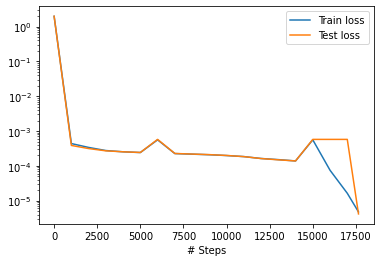

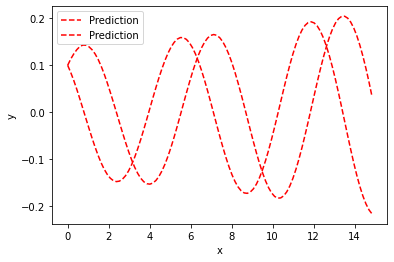

In [6]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=15000)

model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

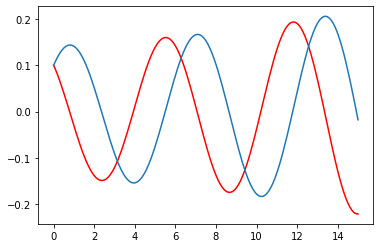

In [7]:
def ivp_nonlin(t,z):
    x,y=z
    return -y + a*x*(x**2+y**2), x + a*y*(x**2+y**2)

x0,y0 = 0.1,0.1
tn = 15
dt = .1
osc_sol = solve_ivp(ivp_nonlin, (0,tn), (x0,y0), method='RK45', t_eval=np.arange(0,tn+dt,dt))
plt.plot(osc_sol.t,osc_sol.y[0], color = 'r')
plt.plot(osc_sol.t,osc_sol.y[1])
plt.show()

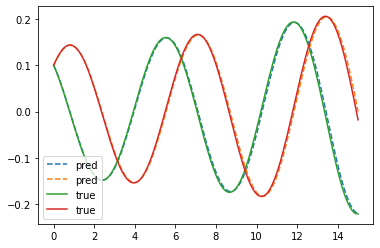

In [8]:
t = np.arange(0,15.1,.1).reshape(151, 1)
model_pred = model.predict(t)
plt.plot(t, model_pred, linestyle = 'dashed', label='pred')
plt.plot(osc_sol.t, osc_sol.y[0], label='true')
plt.plot(osc_sol.t, osc_sol.y[1], label='true')
plt.legend()
plt.show()

In [9]:
print('L2 relative error for x', dde.metrics.l2_relative_error(model_pred[:,0],osc_sol.y[0]))
print('L2 relative error for y', dde.metrics.l2_relative_error(model_pred[:,1],osc_sol.y[1]))

L2 relative error for x 0.05445540731875731
L2 relative error for y 0.05525183910130755


# CASE a=0

In [74]:
a=0

Compiling model...
Building feed-forward neural network...
'build' took 0.053528 s

'compile' took 0.734797 s

Initializing variables...
Training model...

0         [2.91e-01, 8.24e-02, 1.00e+00, 1.00e+00]    [2.94e-01, 8.20e-02, 1.00e+00, 1.00e+00]    []  
1000      [1.20e-02, 1.43e-02, 2.25e-04, 2.08e-04]    [1.25e-02, 1.32e-02, 2.25e-04, 2.08e-04]    []  
2000      [8.15e-03, 8.81e-03, 7.00e-05, 9.09e-05]    [8.43e-03, 8.52e-03, 7.00e-05, 9.09e-05]    []  
3000      [9.13e-03, 7.22e-03, 2.52e-04, 4.15e-04]    [9.64e-03, 7.35e-03, 2.52e-04, 4.15e-04]    []  
4000      [5.66e-03, 6.02e-03, 3.66e-05, 4.19e-05]    [5.75e-03, 6.43e-03, 3.66e-05, 4.19e-05]    []  
5000      [5.03e-03, 5.45e-03, 2.99e-05, 3.37e-05]    [5.09e-03, 5.85e-03, 2.99e-05, 3.37e-05]    []  

Best model at step 5000:
  train loss: 1.05e-02
  test loss: 1.10e-02
  test metric: []

'train' took 6.060583 s

Compiling model...
'compile' took 0.916326 s

Training model...

Step      Train loss                          

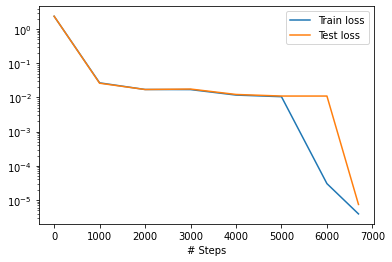

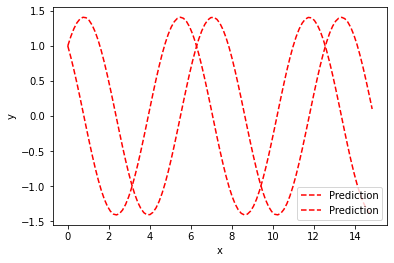

In [81]:
geom = dde.geometry.TimeDomain(0, 15)
ic1 = dde.IC(geom, lambda X: 1, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 1, boundary, component=1)
data = dde.data.PDE(geom, nonlin_center, [ic1, ic2], 100, 2, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

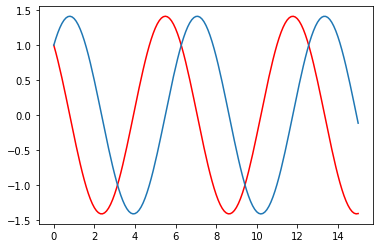

In [78]:
x0,y0 = 1,1
tn = 15
dt = .1
osc_sol = solve_ivp(ivp_nonlin, (0,tn), (x0,y0), method='RK45', t_eval=np.arange(0,tn+dt,dt))
plt.plot(osc_sol.t,osc_sol.y[0], color = 'r')
plt.plot(osc_sol.t,osc_sol.y[1])
plt.show()

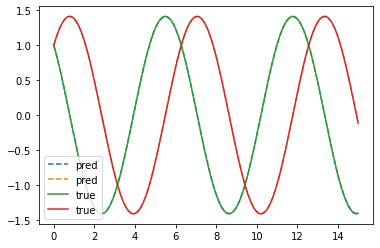

In [82]:
t = np.arange(0,15.1,.1).reshape(151, 1)
model_pred = model.predict(t)
plt.plot(t, model_pred, linestyle = 'dashed', label='pred')
plt.plot(osc_sol.t, osc_sol.y[0], label='true')
plt.plot(osc_sol.t, osc_sol.y[1], label='true')
plt.legend()
plt.show()

In [83]:
print('L2 relative error for x', dde.metrics.l2_relative_error(model_pred[:,0],osc_sol.y[0]))
print('L2 relative error for y', dde.metrics.l2_relative_error(model_pred[:,1],osc_sol.y[1]))

L2 relative error for x 0.004934663533289245
L2 relative error for y 0.004574324855359811


# CASE a < 0

In [149]:
a = -4

Compiling model...
Building feed-forward neural network...
'build' took 0.072203 s



C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:107: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.992541 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.63e-02, 6.05e-02, 1.00e-02, 1.00e-02]    [4.51e-02, 6.06e-02, 1.00e-02, 1.00e-02]    []  
1000      [1.34e-04, 1.43e-04, 1.58e-06, 1.66e-06]    [1.37e-04, 1.24e-04, 1.58e-06, 1.66e-06]    []  
2000      [9.62e-05, 1.08e-04, 9.18e-07, 8.33e-07]    [9.84e-05, 1.06e-04, 9.18e-07, 8.33e-07]    []  
3000      [8.60e-05, 9.98e-05, 6.71e-07, 6.57e-07]    [8.91e-05, 9.95e-05, 6.71e-07, 6.57e-07]    []  
4000      [8.14e-05, 9.45e-05, 5.69e-07, 5.80e-07]    [8.48e-05, 9.42e-05, 5.69e-07, 5.80e-07]    []  
5000      [7.40e-05, 9.10e-05, 4.81e-07, 5.05e-07]    [7.72e-05, 9.04e-05, 4.81e-07, 5.05e-07]    []  
6000      [6.89e-05, 8.46e-05, 3.80e-07, 4.88e-07]    [7.19e-05, 8.40e-05, 3.80e-07, 4.88e-07]    []  
7000      [6.37e-05, 7.68e-05, 4.43e-07, 2.93e-07]    [6.66e-05, 7.59e-05, 4.43e-07, 2.93e-07]   

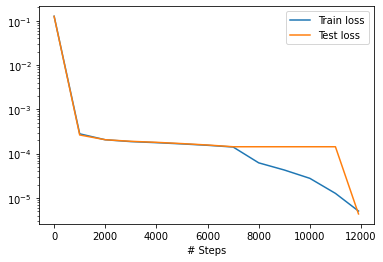

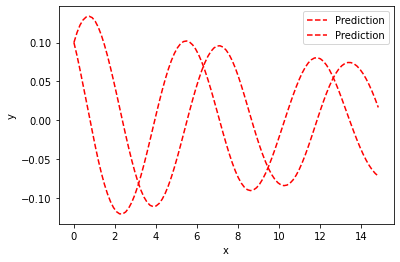

In [167]:
geom = dde.geometry.TimeDomain(0, 15)
ic1 = dde.IC(geom, lambda X: .1, boundary, component=0)
ic2 = dde.IC(geom, lambda X: .1, boundary, component=1)
data = dde.data.PDE(geom, nonlin_center, [ic1, ic2], 100, 2, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
# net.apply_feature_transform(input_transform)

model = dde.Model(data, net)
model.compile("adam", lr=0.0001)
losshistory, train_state = model.train(epochs=7000)

model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

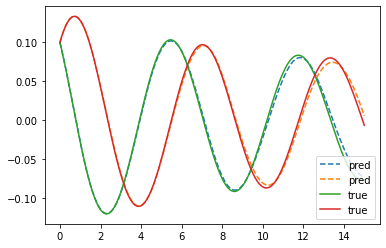

In [168]:
x0,y0 = .1,.1
tn = 15
dt = .1
osc_sol = solve_ivp(ivp_nonlin, (0,tn), (x0,y0), method='RK45', t_eval=np.arange(0,tn+dt,dt))
t = np.arange(0,15.1,.1).reshape(151, 1)
model_pred = model.predict(t)
plt.plot(t, model_pred, linestyle = 'dashed', label='pred')
plt.plot(osc_sol.t, osc_sol.y[0], label='true')
plt.plot(osc_sol.t, osc_sol.y[1], label='true')
plt.legend()
plt.show()

In [169]:
print('L2 relative error for x', dde.metrics.l2_relative_error(model_pred[:,0],osc_sol.y[0]))
print('L2 relative error for y', dde.metrics.l2_relative_error(model_pred[:,1],osc_sol.y[1]))

L2 relative error for x 0.06506022397874298
L2 relative error for y 0.059452926465873454
